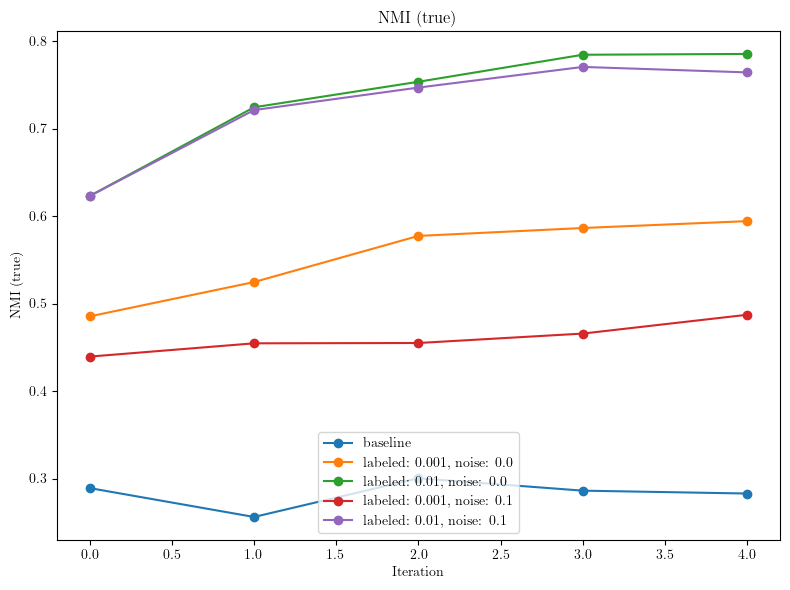

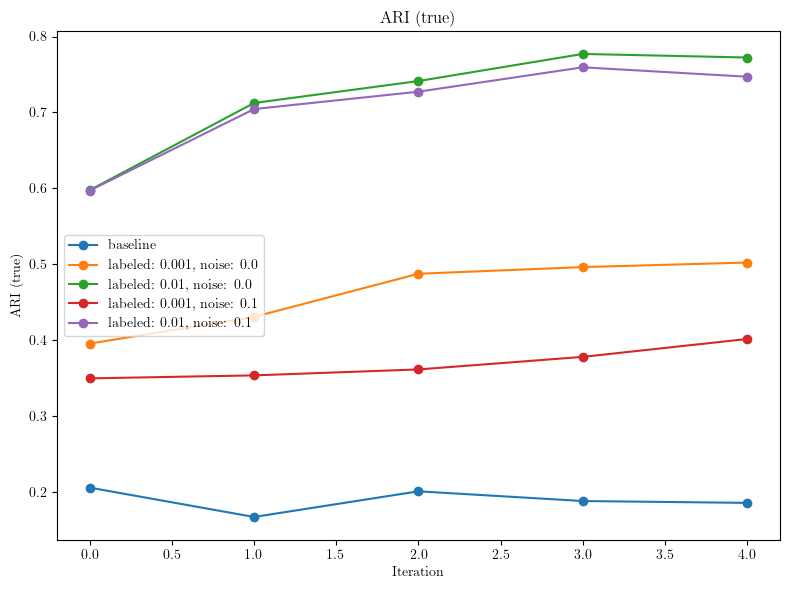

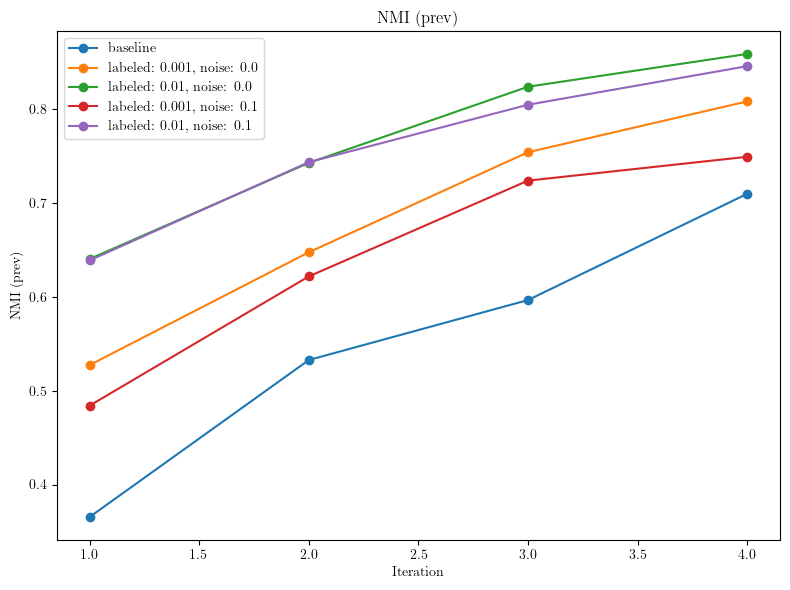

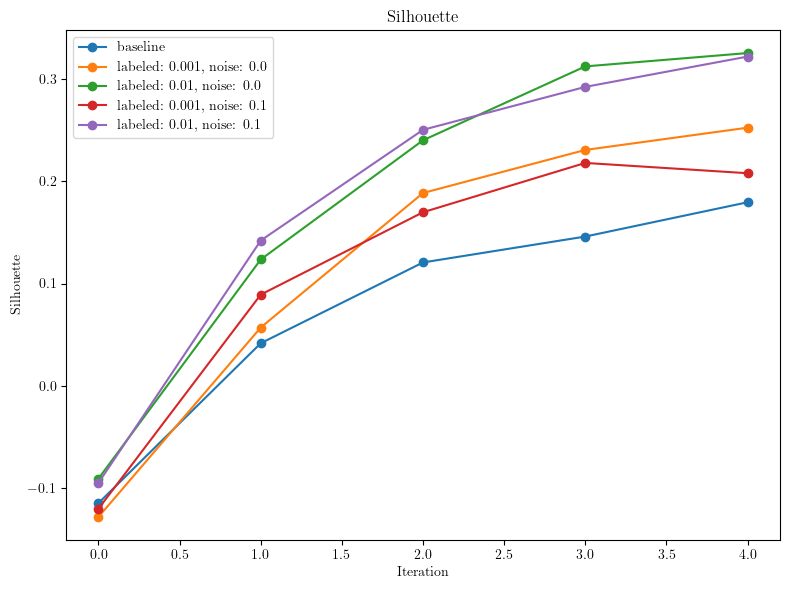

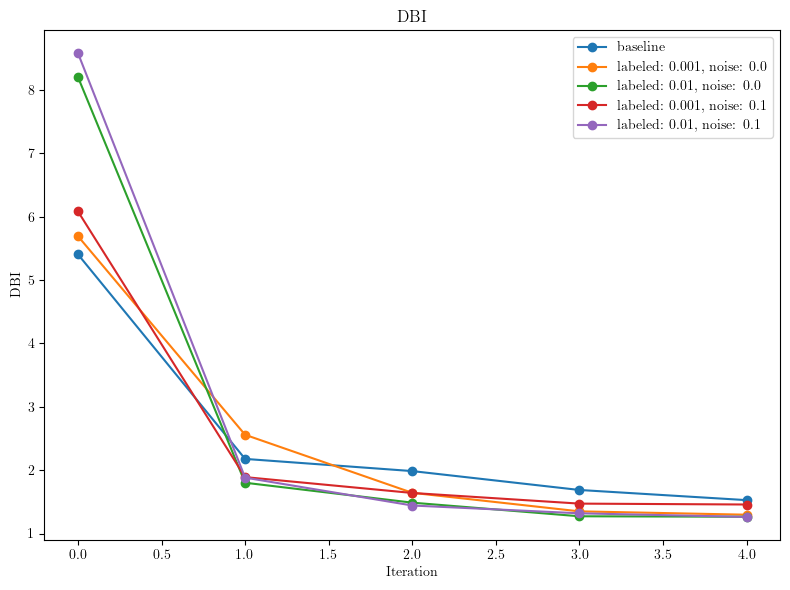

In [14]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

# Enable LaTeX font (optional)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

def load_metrics(run_paths):
    all_data = {}
    for run_name, run_path in run_paths.items():
        metrics_file = os.path.join(run_path, 'metrics.json')
        if os.path.isfile(metrics_file):
            with open(metrics_file, 'r') as f:
                metrics = json.load(f)
            all_data[run_name] = metrics
    return all_data

# Suppose you have paths like:
run_path = './experiments/run_20250107_180402'
run_paths = {
    'baseline': run_path + '/config_1',
    'labeled: 0.001, noise: 0.0': run_path + '/config_2',
    'labeled: 0.01, noise: 0.0': run_path + '/config_3',
    'labeled: 0.001, noise: 0.1': run_path + '/config_4',
    'labeled: 0.01, noise: 0.1': run_path + '/config_5',
}


metrics_dict = load_metrics(run_paths)

# Collect metrics into DataFrames
dfs = {}
for run_name, m in metrics_dict.items():
    dfs[run_name] = pd.DataFrame(m)

# The metrics we care about
metrics_to_plot = ['nmi_true', 'ari_true', 'nmi_prev', 'silhouette', 'dbi']
metrics_legend = {
    'nmi_true': 'NMI (true)',
    'ari_true': 'ARI (true)',
    'nmi_prev': 'NMI (prev)',
    'silhouette': 'Silhouette',
    'dbi': 'DBI',
}


for metric in metrics_to_plot:
    plt.figure(figsize=(8, 6))
    
    # Plot this metric for each config/run
    for run_name, df in dfs.items():
        # Some metrics might have NaN/null (e.g. 'nmi_prev' for iteration 0), so drop them or fill
        plt.plot(df[metric], label=run_name, marker='o')
    
    plt.title(f'{metrics_legend[metric]}')
    plt.xlabel('Iteration')
    plt.ylabel(f'{metrics_legend[metric]}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# Compute the best metrics as before
best_metrics = {}

for run_name, df in dfs.items():
    best_nmi_true = df['nmi_true'].max()
    best_ari_true = df['ari_true'].max()
    best_silhouette = df['silhouette'].max()
    best_dbi = df['dbi'].min()  # lower is better
    
    best_metrics[run_name] = {
        'best_nmi_true': best_nmi_true,
        'best_ari_true': best_ari_true,
        'best_silhouette': best_silhouette,
        'best_dbi': best_dbi
    }

best_metrics_df = pd.DataFrame(best_metrics).T
print(best_metrics_df)

# Now plot this as a table in a figure
fig, ax = plt.subplots(figsize=(6, 2))  # adjust size as needed
ax.axis('off')  # no x or y axes

# Round the values for nicer display
table_vals = best_metrics_df.round(3).values

# Create the table
table = ax.table(
    cellText=table_vals,
    colLabels=best_metrics_df.columns,
    rowLabels=best_metrics_df.index,
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # enlarge the table if needed

plt.title('Best Metrics per Configuration', y=1.08)  # move the title up
plt.tight_layout()
plt.show()


In [ ]:
best_nmi_true_values = best_metrics_df['best_nmi_true']

plt.figure(figsize=(6, 4))
best_nmi_true_values.plot(kind='bar', rot=0)
plt.title('Best NMI vs GT across configurations')
plt.xlabel('Configuration')
plt.ylabel('Best NMI (higher is better)')
plt.ylim(0, 1)  # if you know the range is [0,1]
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose we want to compare these metrics for each config
metrics_for_radar = ['best_nmi_true', 'best_ari_true', 'best_silhouette', 'best_dbi']

# Normalize or invert DBI so that "higher is better" for consistent plotting, e.g. 1 / DBI
radar_df = best_metrics_df.copy()
radar_df['best_dbi'] = 1 / radar_df['best_dbi']  # invert DBI

# Convert DataFrame to array
values = radar_df[metrics_for_radar].values
configs = radar_df.index

# Angles around the circle
num_metrics = len(metrics_for_radar)
angles = np.linspace(0, 2*np.pi, num_metrics, endpoint=False)

# Create subplots
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

for i, config in enumerate(configs):
    # each row in values corresponds to a single config
    stats = values[i]
    stats = np.concatenate((stats, [stats[0]]))  # repeat the first value to close the polygon
    angle_ext = np.concatenate((angles, [angles[0]]))

    ax.plot(angle_ext, stats, label=config, marker='o')
    ax.fill(angle_ext, stats, alpha=0.1)

ax.set_xticks(angles)
ax.set_xticklabels(metrics_for_radar)
ax.set_title('Radar Chart of Best Metrics')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()
